In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import sklearn as sk
import pandas as pd

In [2]:
"""
training_data, validation_data = keras.preprocessing.image_dataset_from_directory(
    './dataset',  # the path to the dataset
    labels='inferred',  # keep the original folder structure (class names)
    label_mode='int',   # use integer labels
    class_names=None,   # class names will be inferred from the folder structure
    color_mode='grayscale',   # the images are MRI scans in grayscale
    batch_size=32,  # images will be fed in batches of 32
    image_size=(224, 224),  # images will be resized to 224x224 pixels - the input size of the VGG16 model
    validation_split=0.2,   # 20% of the images will be used for validation, 80% for training
    subset='both',  # the data generator will return training data
    shuffle=True,   # shuffle the images randomly before training - this is important to avoid overfitting
    seed=42         # provide a seed to ensure no overlap between training and validation subsets
)

print(training_data.class_names)
print(training_data)

"""

"\ntraining_data, validation_data = keras.preprocessing.image_dataset_from_directory(\n    './dataset',  # the path to the dataset\n    labels='inferred',  # keep the original folder structure (class names)\n    label_mode='int',   # use integer labels\n    class_names=None,   # class names will be inferred from the folder structure\n    color_mode='grayscale',   # the images are MRI scans in grayscale\n    batch_size=32,  # images will be fed in batches of 32\n    image_size=(224, 224),  # images will be resized to 224x224 pixels - the input size of the VGG16 model\n    validation_split=0.2,   # 20% of the images will be used for validation, 80% for training\n    subset='both',  # the data generator will return training data\n    shuffle=True,   # shuffle the images randomly before training - this is important to avoid overfitting\n    seed=42         # provide a seed to ensure no overlap between training and validation subsets\n)\n\nprint(training_data.class_names)\nprint(training_da

We should proceed another way to preprocess the data (and especially load it). Since we are not yet quite familiar with TensorFlow or Keras, we will import the data ourselves and preprocess it.

First, let's store the labels in a variable.

In [3]:
dataset_path = "./dataset"

class_names = os.listdir(dataset_path)
class_names = sorted(class_names)
class_names.remove('.DS_Store')
nb_classes = len(class_names)
print(f'The dataset contains {nb_classes} classes: {class_names}')

The dataset contains 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Now, we want to load the images. To do so, we will use the `cv2` library. We will load the images and resize them to 224x224 pixels. We will also normalize the images by dividing them by 255.

Finally, we will split the data into training and validation sets.

In [4]:
# Load the images with cv2

# Create an empty list to store the images
images = []

# Encode the labels as integers, based on the class names
# The dictionary will map class names to integer labels
labels = {class_name: i for i, class_name in enumerate(class_names)}

# Iterate over the class names
for label in labels:
    # Get the list of image filenames
    image_filenames = os.listdir(os.path.join(dataset_path, label))
    # Iterate over the image filenames
    for image_filename in image_filenames:
        # Build the path to the image file
        image_path = os.path.join(dataset_path, label, image_filename)
        # Load the image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Resize the image to 224x224 pixels
        image = cv2.resize(image, (224, 224))
        # Normalize the image
        image = image / 255.0
        # Add the image to the list
        images.append([image, label])
        
# Shuffle the images
np.random.shuffle(images)

Shape of an image is (224, 224)


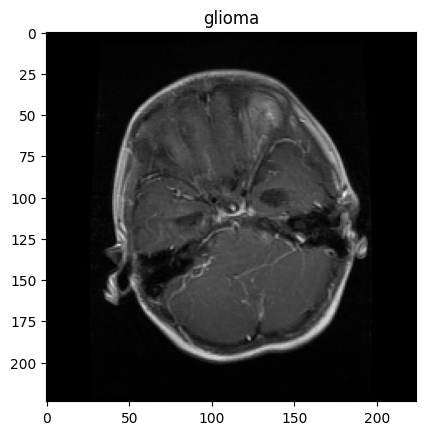

In [19]:
# Display a random image
rd = np.random.randint(0, len(images))
image, label = images[rd]
print(f'Shape of an image is {np.array(image).shape}')
plt.imshow(image, cmap='gray')
plt.title(label)
plt.show()

In [9]:
df = pd.DataFrame(images, columns=['image', 'label'])
df['label'] = df['label'].map(labels)
df.head()

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
1,"[[0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0...",3
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [10]:
df_labels = pd.DataFrame(list(labels.items()), columns=['label', 'label_id'])
df_labels.head()

,label,label_id
0,glioma,0
1,meningioma,1
2,notumor,2
3,pituitary,3


The data has now been preprocessed, which means :
- the images have all been resied to the shape (224 x 224)
- the pixel values have been normalised (/255)
- the images have been loaded in greyscale

We can now split the data into two datasets : the training set and the testing set.

In [15]:
X = df['image']
y = df['label']
X.head()

0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1    [[0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0...
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: image, dtype: object

In [16]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

Now we are ready to train, then test, our neural network. For this model, we will first implement a VGG-16 CNN.

In [25]:
X_train = np.reshape(X_train, (len(X_train), 224, 224, 1))

ValueError: cannot reshape array of size 3998 into shape (3998,224,224,1)

Error in handling the data - should use a list of arrays probably before splitting the data into two subsets